In [ ]:
import tensorflow as tf
import numpy as np


# In[112]:
num_classes = 513
IMAGE_WIDTH = 64
IMAGE_HEIGHT = 64

class Model:
    
    def __init__(self):
        pass
    
    def _init_and_build_net(self):
        tf.reset_default_graph()
        tf.initialize_all_variables()
        sess = tf.Session()
        self.sess = sess
        self._build_net_2()
        sess.run(tf.global_variables_initializer())
        
    def _save_network(self):
        saver = tf.train.Saver()
        saver.save(self.sess, './hangeul_cnn.ckpt')
    
    def weight_variable(self, shape):
        initial = tf.random.truncated_normal(shape, stddev=0.1)
        return tf.Variable(initial)
    
    def bias_variable(self, shape):
        initial = tf.constant(0.1, shape=shape)
        return tf.Variable(initial)
    
    def _restore_network(self):
        self.sess = tf.InteractiveSession()
        saver = tf.train.import_meta_graph('./hangeul_cnn.ckpt.meta')
        saver.restore(self.sess,'./hangeul_cnn.ckpt')
        
        graph = tf.get_default_graph()
        self.X =  self.sess.graph.get_tensor_by_name("Placeholder:0")
        self.Y =  self.sess.graph.get_tensor_by_name("Placeholder_1:0")
        self.W_conv1 = self.sess.graph.get_tensor_by_name("W1:0")
        self.W_conv2 = self.sess.graph.get_tensor_by_name("W2:0")
        self.W_conv3 = self.sess.graph.get_tensor_by_name("W3:0")
        self.b_conv1 = self.sess.graph.get_tensor_by_name("Variable:0")
        self.b_conv2 = self.sess.graph.get_tensor_by_name("Variable_1:0")
        self.b_conv3 = self.sess.graph.get_tensor_by_name("Variable_2:0")
        self.cross_entropy = self.sess.graph.get_tensor_by_name("Mean:0")
        self.train_step = self.sess.graph.get_operation_by_name("Adam")
        self.accuracy = self.sess.graph.get_tensor_by_name("Mean_1:0")
        self.W_fc1 = self.sess.graph.get_tensor_by_name("W4:0")
        self.b_fc1 = self.sess.graph.get_tensor_by_name("Variable_3:0")
        self.W_fc2 = self.sess.graph.get_tensor_by_name("W5:0")
        self.b_fc2 = self.sess.graph.get_tensor_by_name("Variable_4:0")
        self.y_logits = self.sess.graph.get_tensor_by_name("add_4:0")
        self.keep_prob =  self.sess.graph.get_tensor_by_name("Placeholder_2:0")
        
    def _build_net_2(self):
        self.X = tf.placeholder(tf.float32, [None, IMAGE_WIDTH*IMAGE_HEIGHT])
        self.Y = tf.placeholder(tf.float32, [None, num_classes])

        # Reshape the image back into two dimensions so we can perform convolution.
        x_image = tf.reshape(self.X, [-1, IMAGE_WIDTH, IMAGE_HEIGHT, 1])

        #self.W_conv1 = self.weight_variable([5, 5, 1, 32])
        self.W_conv1 = tf.get_variable("W1", shape=[5, 5, 1, 32], initializer=tf.contrib.layers.xavier_initializer())
        
        self.b_conv1 = self.bias_variable([32])
        x_conv1 = tf.nn.conv2d(x_image, self.W_conv1, strides=[1, 1, 1, 1],
                               padding='SAME')
        h_conv1 = tf.nn.relu(x_conv1 + self.b_conv1)

        # Max-pooling.
        h_pool1 = tf.nn.max_pool(h_conv1, ksize=[1, 2, 2, 1],
                                 strides=[1, 2, 2, 1], padding='SAME')

        # Second convolutional layer. 64 feature maps.
        
        #self.W_conv2 = self.weight_variable([5, 5, 32, 64])
        self.W_conv2  = tf.get_variable("W2", shape=[5, 5, 32, 64], initializer=tf.contrib.layers.xavier_initializer())
        self.b_conv2 = self.bias_variable([64])
        x_conv2 = tf.nn.conv2d(h_pool1, self.W_conv2, strides=[1, 1, 1, 1],
                               padding='SAME')
        h_conv2 = tf.nn.relu(x_conv2 + self.b_conv2)

        h_pool2 = tf.nn.max_pool(h_conv2, ksize=[1, 2, 2, 1],
                                 strides=[1, 2, 2, 1], padding='SAME')

        # Third convolutional layer. 128 feature maps.
        
        #self.W_conv3 = self.weight_variable([3, 3, 64, 128])
        self.W_conv3  = tf.get_variable("W3", shape=[3, 3, 64, 128], initializer=tf.contrib.layers.xavier_initializer())
        self.b_conv3 = self.bias_variable([128])
        x_conv3 = tf.nn.conv2d(h_pool2, self.W_conv3, strides=[1, 1, 1, 1],
                               padding='SAME')
        h_conv3 = tf.nn.relu(x_conv3 + self.b_conv3)

        h_pool3 = tf.nn.max_pool(h_conv3, ksize=[1, 2, 2, 1],
                                 strides=[1, 2, 2, 1], padding='SAME')

        # Fully connected layer. Here we choose to have 1024 neurons in this layer.
        h_pool_flat = tf.reshape(h_pool3, [-1, 8*8*128])
        #self.W_fc1 = self.weight_variable([8*8*128, 1024])
        self.W_fc1 = tf.get_variable("W4", shape=[8*8*128, 1024], initializer=tf.contrib.layers.xavier_initializer())
        self.b_fc1 = self.bias_variable([1024])
        h_fc1 = tf.nn.relu(tf.matmul(h_pool_flat, self.W_fc1) + self.b_fc1)

        # Dropout layer. This helps fight overfitting.
        self.keep_prob = tf.placeholder(tf.float32)
        h_fc1_drop = tf.nn.dropout(h_fc1, rate=1-self.keep_prob)

        # Classification layer.
        #self.W_fc2 = self.weight_variable([1024, num_classes])
        self.W_fc2 = tf.get_variable("W5", shape=[1024, num_classes], initializer=tf.contrib.layers.xavier_initializer())
        self.b_fc2 = self.bias_variable([num_classes])
        self.y_logits = tf.matmul(h_fc1_drop, self.W_fc2) + self.b_fc2

        # This isn't used for training, but for when using the saved model.
        tf.nn.softmax(self.y_logits)

        # Define our loss.
        self.cross_entropy = tf.reduce_mean(
            tf.nn.softmax_cross_entropy_with_logits_v2(
                labels=tf.stop_gradient(self.Y),
                logits=self.y_logits
            )
        )

        # Define our optimizer for minimizing our loss. Here we choose a learning
        # rate of 0.0001 with AdamOptimizer. This utilizes someting
        # called the Adam algorithm, and utilizes adaptive learning rates and
        # momentum to get past saddle points.
        self.train_step = tf.train.AdamOptimizer(0.001).minimize(self.cross_entropy)

        # Define accuracy.
        correct_prediction = tf.equal(tf.argmax(self.y_logits, 1), tf.argmax(self.Y, 1))
        correct_prediction = tf.cast(correct_prediction, tf.float32)
        self.accuracy = tf.reduce_mean(correct_prediction)
        print("net_complete")
        
    
    
    def result_to_str(self, x_test):
        return str(self.sess.run(tf.argmax(self.y_logits, 1), feed_dict={self.X: x_test, self.keep_prob: 1.0})[0])
    
    def predict(self, x_test):
        return self.sess.run(self.y_logits, feed_dict={self.X: x_test, self.keep_prob: 1.0})
    
    def get_accuracy(self):
        x_test = np.load('hangeul_test_input.npy')
        y_test = np.load('hangeul_test_label.npy')
        return self.sess.run(self.accuracy, feed_dict={self.X: x_test, self.Y: y_test, self.keep_prob: 1.0})
    
    def train(self, x_data, y_data):
        return self.sess.run([self.cross_entropy, self.train_step], feed_dict={self.X: x_data, self.Y: y_data, self.keep_prob: 0.5})
    
    def training(self, epochs, input_name, label_name):
        training_epochs = epochs
        batch_size = 100
        
        train_input = np.load(input_name)
        train_label = np.load(label_name)
        
        print('Learning Started!')

        for epoch in range(training_epochs):
            avg_cost = 0
            total_batch = int(len(train_input) / batch_size)
 
            for i in range(total_batch):
                start = ((i+1) * batch_size) - batch_size
                end = ((i+1) * batch_size)
                batch_xs = train_input[start:end]
                batch_ys = train_label[start:end]
                
                #if i%100 == 0:
                #    train_accuracy = self.sess.run(self.accuracy, feed_dict={self.X: batch_xs, self.Y: batch_ys, self.keep_prob: 1.0})
                #    print("Step %d, Training Accuracy %g" %(i, float(train_accuracy)))
                c, _ = self.train(batch_xs, batch_ys)
                avg_cost += c / total_batch
 
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))
 
        print('Learning Finished!')


    

In [2]:
m1 = Model()

In [3]:
m1._init_and_build_net()

Instructions for updating:
Use `tf.global_variables_initializer` instead.
ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'init' type=NoOp>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
  File "C:\Users\kvlks\Miniconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)  File "C:\Users\kvlks\Miniconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)  File "C:\Users\kvlks\Miniconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()  File "C:\Users\kvlks\Miniconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()  File "C:\Users\kvlks\Miniconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()  File "C:\Users\kvlks\Miniconda3\lib\site-packages\tornado\ioloop.py", line 832, in 

In [5]:
m1.training(30, 'hangeul_train_input.npy', 'hangeul_train_label.npy')

Learning Started!
Epoch: 0001 cost = 0.306380298
Epoch: 0002 cost = 0.044279438
Epoch: 0003 cost = 0.031058883
Epoch: 0004 cost = 0.026629116
Epoch: 0005 cost = 0.024108576
Epoch: 0006 cost = 0.022574488
Epoch: 0007 cost = 0.021515252
Epoch: 0008 cost = 0.021458248
Epoch: 0009 cost = 0.019943824
Epoch: 0010 cost = 0.021052545
Epoch: 0011 cost = 0.018491548
Epoch: 0012 cost = 0.019670007
Epoch: 0013 cost = 0.019601093
Epoch: 0014 cost = 0.019108424
Epoch: 0015 cost = 0.019673724
Epoch: 0016 cost = 0.016564341
Epoch: 0017 cost = 0.016514353
Epoch: 0018 cost = 0.017064375
Epoch: 0019 cost = 0.016405483
Epoch: 0020 cost = 0.017025958
Epoch: 0021 cost = 0.015301475
Epoch: 0022 cost = 0.015437943
Epoch: 0023 cost = 0.016968500
Epoch: 0024 cost = 0.014251603
Epoch: 0025 cost = 0.013343234
Epoch: 0026 cost = 0.014237814
Epoch: 0027 cost = 0.014914141
Epoch: 0028 cost = 0.012707815
Epoch: 0029 cost = 0.014508746
Epoch: 0030 cost = 0.013708100
Learning Finished!


In [7]:
#m1._save_network()

In [3]:
m1._restore_network()

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ./hangeul_cnn.ckpt


In [8]:
print('Accuracy:', m1.get_accuracy())

ResourceExhaustedError: OOM when allocating tensor with shape[25137,32,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Conv2D (defined at <ipython-input-1-eb9c71f8a2c1>:69) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[node Mean_1 (defined at <ipython-input-1-eb9c71f8a2c1>:137) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


Caused by op 'Conv2D', defined at:
  File "C:\Users\kvlks\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\kvlks\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 505, in start
    self.io_loop.start()
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 148, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\kvlks\Anaconda3\lib\asyncio\base_events.py", line 539, in run_forever
    self._run_once()
  File "C:\Users\kvlks\Anaconda3\lib\asyncio\base_events.py", line 1775, in _run_once
    handle._run()
  File "C:\Users\kvlks\Anaconda3\lib\asyncio\events.py", line 88, in _run
    self._context.run(self._callback, *self._args)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\tornado\ioloop.py", line 690, in <lambda>
    lambda f: self._run_callback(functools.partial(callback, future))
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\tornado\ioloop.py", line 743, in _run_callback
    ret = callback()
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\tornado\gen.py", line 781, in inner
    self.run()
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\tornado\gen.py", line 742, in run
    yielded = self.gen.send(value)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 357, in process_one
    yield gen.maybe_future(dispatch(*args))
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 267, in dispatch_shell
    yield gen.maybe_future(handler(stream, idents, msg))
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 534, in execute_request
    user_expressions, allow_stdin,
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\tornado\gen.py", line 209, in wrapper
    yielded = next(result)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 294, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 536, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2848, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2874, in _run_cell
    return runner(coro)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 67, in _pseudo_sync_runner
    coro.send(None)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3049, in run_cell_async
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3220, in run_ast_nodes
    if (yield from self.run_code(code, result)):
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3296, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-3-368a0d11b88d>", line 1, in <module>
    m1._init_and_build_net()
  File "<ipython-input-1-eb9c71f8a2c1>", line 19, in _init_and_build_net
    self._build_net_2()
  File "<ipython-input-1-eb9c71f8a2c1>", line 69, in _build_net_2
    padding='SAME')
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_nn_ops.py", line 1026, in conv2d
    data_format=data_format, dilations=dilations, name=name)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\kvlks\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[25137,32,64,64] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[node Conv2D (defined at <ipython-input-1-eb9c71f8a2c1>:69) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[node Mean_1 (defined at <ipython-input-1-eb9c71f8a2c1>:137) ]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.



In [4]:
ORDER_FILE_PATH = "C:/DataSet/Hangeul/order.txt"
order_file = open(ORDER_FILE_PATH, 'r')
hangeul_order_list = order_file.readlines()

In [5]:
print(len(hangeul_order_list))
print(list(enumerate(hangeul_order_list)))

513
[(0, '가\n'), (1, '각\n'), (2, '간\n'), (3, '갈\n'), (4, '감\n'), (5, '갑\n'), (6, '강\n'), (7, '갖\n'), (8, '같\n'), (9, '개\n'), (10, '객\n'), (11, '거\n'), (12, '걱\n'), (13, '건\n'), (14, '걷\n'), (15, '걸\n'), (16, '검\n'), (17, '겁\n'), (18, '것\n'), (19, '게\n'), (20, '겨\n'), (21, '격\n'), (22, '견\n'), (23, '결\n'), (24, '경\n'), (25, '계\n'), (26, '고\n'), (27, '곡\n'), (28, '곤\n'), (29, '곧\n'), (30, '골\n'), (31, '곳\n'), (32, '공\n'), (33, '과\n'), (34, '관\n'), (35, '광\n'), (36, '괴\n'), (37, '교\n'), (38, '구\n'), (39, '국\n'), (40, '군\n'), (41, '굳\n'), (42, '궁\n'), (43, '권\n'), (44, '귀\n'), (45, '규\n'), (46, '그\n'), (47, '극\n'), (48, '근\n'), (49, '글\n'), (50, '금\n'), (51, '급\n'), (52, '기\n'), (53, '긴\n'), (54, '길\n'), (55, '김\n'), (56, '깊\n'), (57, '까\n'), (58, '깔\n'), (59, '깨\n'), (60, '꺼\n'), (61, '껏\n'), (62, '께\n'), (63, '꼭\n'), (64, '꽃\n'), (65, '꾸\n'), (66, '끄\n'), (67, '끊\n'), (68, '끌\n'), (69, '끗\n'), (70, '끝\n'), (71, '끼\n'), (72, '나\n'), (73, '난\n'), (74, '날\n'), (75, '남\n'), (76, '낮\n'), (77,

In [20]:
import shutil
import cv2
import matplotlib.pyplot as plt

def img_to_vector():
    my_img_path = 'C:/DataSet/input.png'
    temp_img_path = 'C:/DataSet/temp.png'

    shutil.copy(my_img_path, temp_img_path)

    temp_img = cv2.imread(temp_img_path, cv2.IMREAD_GRAYSCALE)

    plt.imshow(temp_img, cmap="Greys", interpolation='nearest')
    plt.show()
    
    temp_img = cv2.resize(temp_img, (64,64))
    temp_img = cv2.bitwise_not(temp_img)
    plt.imshow(temp_img, cmap="Greys", interpolation='nearest')
    plt.show()

    cv2.imwrite(temp_img_path, temp_img)
    return temp_img.reshape(-1,4096)

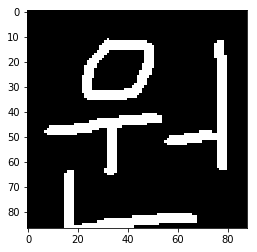

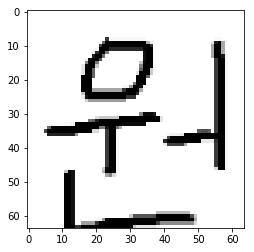

[1]: [원]: -42.334938
[2]: [씨]: -46.692932
[3]: [빌]: -49.290947
[4]: [찌]: -49.82004
[5]: [권]: -50.86486


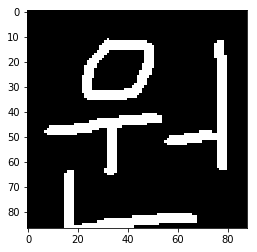

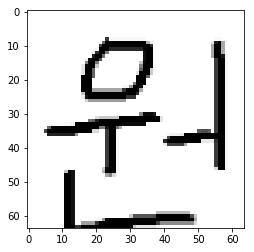

Prediction: 335


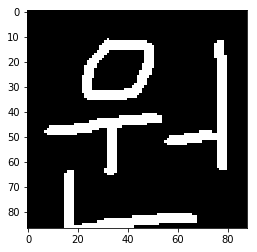

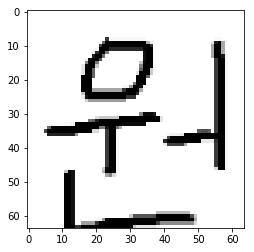

Prediction: 원



In [23]:
result = list(m1.predict(img_to_vector())[0])
for i in range(5):
    index = result.index(max(result))
    print("[%s]: "%str(i+1) + "[%s]: "%hangeul_order_list[index].strip() + str(result[index]))
    result[index] = -999
print("Prediction:", m1.result_to_str(img_to_vector()))
print("Prediction:", hangeul_order_list[int(m1.result_to_str(img_to_vector()))])

In [11]:
m1.keep_prob

<tf.Tensor 'Placeholder_2:0' shape=<unknown> dtype=float32>

In [ ]:
        self.X =  self.sess.graph.get_tensor_by_name("Placeholder:0")
        self.Y =  self.sess.graph.get_tensor_by_name("Placeholder_1:0")
        self.W_conv1 = self.sess.graph.get_tensor_by_name("W1:0")
        self.W_conv2 = self.sess.graph.get_tensor_by_name("W2:0")
        self.W_conv3 = self.sess.graph.get_tensor_by_name("W3:0")
        self.b_conv1 = self.sess.graph.get_tensor_by_name("Variable:0")
        self.b_conv2 = self.sess.graph.get_tensor_by_name("Variable_1:0")
        self.b_conv3 = self.sess.graph.get_tensor_by_name("Variable_2:0")
        self.cross_entropy = self.sess.graph.get_tensor_by_name("Mean:0")
        self.train_step = self.sess.graph.get_operation_by_name("Adam")
        self.accuracy = self.sess.graph.get_tensor_by_name("Mean_1:0")
        self.W_fc1 = self.sess.graph.get_tensor_by_name("W4:0")
        self.b_fc1 = self.sess.graph.get_tensor_by_name("Variable_3:0")
        self.W_fc2 = self.sess.graph.get_tensor_by_name("W5:0")
        self.b_fc2 = self.sess.graph.get_tensor_by_name("Variable_4:0")
        self.y_logits = self.sess.graph.get_tensor_by_name("add_4:0")